<a href="https://colab.research.google.com/github/Chi36/forestfire/blob/main/Forestfireprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preprocessing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_excel('/content/wildfire_prediction_multi_output_dataset_v2.xlsx')

# Display the first few rows
print(df.head())

   Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
0         27.733250     89.108222          13.165364      44.032705   
1         28.789452     21.543283          37.853201      42.478192   
2         30.256666     72.335215          19.592377      12.104919   
3         17.856476     84.138818           5.448178            NaN   
4         34.260178     62.698878          13.356131      27.465001   

   Fuel Moisture (%) Vegetation Type  Slope (%) Region  Fire Size (hectares)  \
0          16.072075       Grassland  59.615524  South            442.648940   
1          25.176666          Forest  26.995937  South             17.689832   
2          22.251979       Shrubland  55.623107  South            256.142917   
3          20.820927          Forest   3.944492   East            165.111292   
4           6.842731       Shrubland  54.280029   West            160.298123   

   Fire Duration (hours)  Suppression Cost ($) Fire Occurrence  
0              11.616707   

In [2]:
# Basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperature (°C)       4753 non-null   float64
 1   Humidity (%)           4750 non-null   float64
 2   Wind Speed (km/h)      4750 non-null   float64
 3   Rainfall (mm)          4750 non-null   float64
 4   Fuel Moisture (%)      4750 non-null   float64
 5   Vegetation Type        5000 non-null   object 
 6   Slope (%)              5000 non-null   float64
 7   Region                 5000 non-null   object 
 8   Fire Size (hectares)   4756 non-null   float64
 9   Fire Duration (hours)  4750 non-null   float64
 10  Suppression Cost ($)   4750 non-null   float64
 11  Fire Occurrence        5000 non-null   object 
dtypes: float64(9), object(3)
memory usage: 468.9+ KB
None


Summary Statistics

In [3]:
# Summary statistics
print(df.describe())

       Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
count       4753.000000   4750.000000        4750.000000    4750.000000   
mean          30.559802     49.377604          20.147253      25.295303   
std            9.402463     23.205739          11.539852      14.435450   
min           15.002875     10.003265           0.031548       0.010413   
25%           22.539120     29.010613          10.172871      12.924704   
50%           30.503760     48.865124          20.134280      25.452002   
75%           37.984770     69.060730          30.397929      37.959436   
max           56.131937     89.974529          39.997698      49.999283   

       Fuel Moisture (%)    Slope (%)  Fire Size (hectares)  \
count        4750.000000  5000.000000           4756.000000   
mean           22.510023    29.956677            263.269659   
std            10.046614    17.301284            176.795086   
min             5.005384     0.015012              0.078304   
25%      

Checking for missing values



In [4]:
import pandas as pd

# Load your dataset into a DataFrame
df = pd.read_excel('/content/wildfire_prediction_multi_output_dataset_v2.xlsx')

# Check for missing values
missing_values = df.isnull().sum()

# Print the count of missing values for each column
print("Missing values per column:")
print(missing_values)

# Check if there are any missing values in the entire DataFrame
has_missing_values = df.isnull().any().any()
print("Has missing values:", has_missing_values)

Missing values per column:
Temperature (°C)         247
Humidity (%)             250
Wind Speed (km/h)        250
Rainfall (mm)            250
Fuel Moisture (%)        250
Vegetation Type            0
Slope (%)                  0
Region                     0
Fire Size (hectares)     244
Fire Duration (hours)    250
Suppression Cost ($)     250
Fire Occurrence            0
dtype: int64
Has missing values: True


#Imputation

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Step 1: Load the data
df = pd.read_excel('/content/wildfire_prediction_multi_output_dataset_v2.xlsx')  # Replace with your actual file path

# Step 2: Identify numerical columns (exclude non-relevant columns like 'Unnamed: 0')
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns  # Numerical columns
numerical_columns = [col for col in numerical_columns if 'Unnamed' not in col]  # Remove 'Unnamed' columns
print("Numerical columns:", numerical_columns)  # Debugging: Check the numerical columns

# Step 3: Check if there are numerical columns
if len(numerical_columns) > 0:
    # Step 4: Impute missing values for numerical columns (using median for numerical columns)
    imputer_num = SimpleImputer(strategy='median')  # Using median for numerical columns

    # Ensure that we have valid numerical columns to impute
    df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])

# Step 5: Verify the imputation for numerical columns
print("\nAfter numerical imputation, missing data summary:")
print(df.isnull().sum())  # Check if there are still any missing values

# Step 6: Save the cleaned dataset (optional)
df.to_excel('cleaned_data_no_missing_values_numerical.xlsx', index=False)  # Save the cleaned dataset to a new Excel file

Numerical columns: ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Rainfall (mm)', 'Fuel Moisture (%)', 'Slope (%)', 'Fire Size (hectares)', 'Fire Duration (hours)', 'Suppression Cost ($)']

After numerical imputation, missing data summary:
Temperature (°C)         0
Humidity (%)             0
Wind Speed (km/h)        0
Rainfall (mm)            0
Fuel Moisture (%)        0
Vegetation Type          0
Slope (%)                0
Region                   0
Fire Size (hectares)     0
Fire Duration (hours)    0
Suppression Cost ($)     0
Fire Occurrence          0
dtype: int64


#Recheck missing values

In [6]:
import pandas as pd
import numpy as np

# df = pd.read_excel('/content/cleaned_data_no_missing_values_numerical.xlsx')

# Step 1: Identify numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Generate synthetic data for missing numerical values
for col in numerical_columns:
    # Get the column data
    data = df[col]


# Step 2: Verify the result
print(f"Data shape after imputation: {df.shape}")
print(f"Missing values after imputation:\n{df.isnull().sum()}")

Data shape after imputation: (5000, 12)
Missing values after imputation:
Temperature (°C)         0
Humidity (%)             0
Wind Speed (km/h)        0
Rainfall (mm)            0
Fuel Moisture (%)        0
Vegetation Type          0
Slope (%)                0
Region                   0
Fire Size (hectares)     0
Fire Duration (hours)    0
Suppression Cost ($)     0
Fire Occurrence          0
dtype: int64


#Check for outliers

In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# df = pd.read_excel('/content/cleaned_data_no_missing_values_numerical.xlsx')

# Step 1: Identify numerical columns in the DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Function to detect outliers using Z-score
def detect_outliers_zscore(df, columns, threshold=3):
    outliers = pd.DataFrame()  # Initialize an empty DataFrame to store outlier information
    for col in columns:
        # Calculate the Z-score for the column
        z_scores = stats.zscore(df[col].dropna())  # Drop NaN values before calculating z-score
        # Identify outliers: If Z-score > threshold, consider it an outlier
        outlier_idx = np.where(np.abs(z_scores) > threshold)[0]
        if len(outlier_idx) > 0:
            outliers[col] = df.iloc[outlier_idx][col]
    return outliers

# Step 3: Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outliers = pd.DataFrame()  # Initialize an empty DataFrame to store outlier information
    for col in columns:
        # Calculate the Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers: If data is below lower bound or above upper bound, it's an outlier
        outlier_idx = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        if len(outlier_idx) > 0:
            outliers[col] = df.loc[outlier_idx, col]
    return outliers

# Step 4: Detect outliers using Z-score
zscore_outliers = detect_outliers_zscore(df, numerical_columns)

# Step 5: Detect outliers using IQR
iqr_outliers = detect_outliers_iqr(df, numerical_columns)

# Step 6: Print outliers detected by both methods
print("Outliers detected using Z-score method:")
print(zscore_outliers)

print("\nOutliers detected using IQR method:")
print(iqr_outliers)

# Optionally, you can save the outliers to an Excel file:
# zscore_outliers.to_excel('zscore_outliers.xlsx', index=False)
# iqr_outliers.to_excel('iqr_outliers.xlsx', index=False)

Outliers detected using Z-score method:
      Fire Size (hectares)
63              971.349463
101             971.349463
170             971.349463
183             971.349463
347             971.349463
...                    ...
4627            971.349463
4687            971.349463
4841            971.349463
4842            971.349463
4957            971.349463

[100 rows x 1 columns]

Outliers detected using IQR method:
      Fire Size (hectares)
63              971.349463
101             971.349463
170             971.349463
183             971.349463
347             971.349463
...                    ...
4627            971.349463
4687            971.349463
4841            971.349463
4842            971.349463
4957            971.349463

[100 rows x 1 columns]


#Check for categorical variables

In [8]:
# Get the data types of each column
data_types = df.dtypes

# Print the data types
print(data_types)

# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("\nNumeric columns:", numeric_cols)
print("\nCategorical columns:", categorical_cols)

Temperature (°C)         float64
Humidity (%)             float64
Wind Speed (km/h)        float64
Rainfall (mm)            float64
Fuel Moisture (%)        float64
Vegetation Type           object
Slope (%)                float64
Region                    object
Fire Size (hectares)     float64
Fire Duration (hours)    float64
Suppression Cost ($)     float64
Fire Occurrence           object
dtype: object

Numeric columns: Index(['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)',
       'Rainfall (mm)', 'Fuel Moisture (%)', 'Slope (%)',
       'Fire Size (hectares)', 'Fire Duration (hours)',
       'Suppression Cost ($)'],
      dtype='object')

Categorical columns: Index(['Vegetation Type', 'Region', 'Fire Occurrence'], dtype='object')


#Heatmaps

Remove categorical variables before plotting heatmaps


Numerical DataFrame (Categorical Variables Removed):
   Temperature (°C)  Humidity (%)  Wind Speed (km/h)  Rainfall (mm)  \
0         27.733250     89.108222          13.165364      44.032705   
1         28.789452     21.543283          37.853201      42.478192   
2         30.256666     72.335215          19.592377      12.104919   
3         17.856476     84.138818           5.448178      25.452002   
4         34.260178     62.698878          13.356131      27.465001   

   Fuel Moisture (%)  Slope (%)  Fire Size (hectares)  Fire Duration (hours)  \
0          16.072075  59.615524            442.648940              11.616707   
1          25.176666  26.995937             17.689832               6.011346   
2          22.251979  55.623107            256.142917             117.204594   
3          20.820927   3.944492            165.111292              38.125806   
4           6.842731  54.280029            160.298123              15.668068   

   Suppression Cost ($)  
0         49

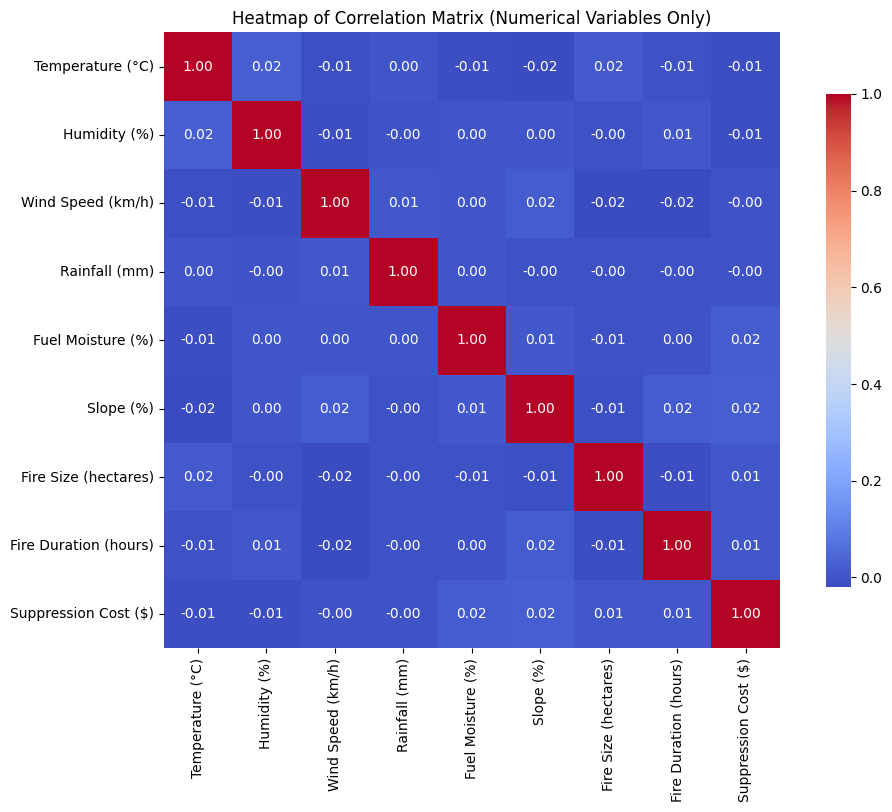

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_excel('/content/cleaned_data_no_missing_values_numerical.xlsx')

# Remove categorical variables
data_numerical = data.select_dtypes(include=['float64', 'int64'])

# Display the numerical DataFrame
print("\nNumerical DataFrame (Categorical Variables Removed):")
print(data_numerical.head())

# Calculate the correlation matrix
correlation_matrix = data_numerical.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,            # Annotate cells with correlation coefficients
    fmt=".2f",            # Format for the annotation
    cmap='coolwarm',      # Color map for the heatmap
    square=True,          # Make cells square-shaped
    cbar_kws={"shrink": .8}  # Adjust color bar size
)

plt.title('Heatmap of Correlation Matrix (Numerical Variables Only)')
plt.show()

#Training and selection of appropriate model

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Load your dataset (replace with actual dataset for fire prediction)
df = pd.read_excel('/content/cleaned_data_no_missing_values_numerical.xlsx')

# Print column names to verify
print("Columns in the dataset:", df.columns)

# Remove categorical columns before training (drop columns with object data type)
df = df.select_dtypes(include=[np.number])

# List of feature columns relevant to fire prediction (numeric columns only)
features = [col for col in df.columns if col != 'Fire Size (Hectares)' and col != 'Fire Duration' and col != 'Suppression Cost' and col != 'Fire Occurrence']

# Define target variables (fire metrics) - Update these if necessary
target_variables = ['Fire Size (Hectares)', 'Fire Duration', 'Suppression Cost', 'Fire Occurrence']

# Check if target columns exist after removing categorical variables
for target in target_variables:
    if target not in df.columns:
        print(f"Warning: Target variable '{target}' not found in dataset.")
    else:
        print(f"Target variable '{target}' is present.")

# Dictionary to hold the best models
best_models = {}

# Train models for each fire metric
for target_variable in target_variables:
    # Ensure target variable exists in the dataframe
    if target_variable not in df.columns:
        print(f"Skipping model training for '{target_variable}' as it is not in the dataset.")
        continue

    # Prepare the feature set (X) and current target variable (y)
    X = df[features]
    y = df[target_variable]

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the models to evaluate
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(),
        "Support Vector Regressor": SVR(),
        "K-Neighbors Regressor": KNeighborsRegressor(),
        "Decision Tree Regressor": DecisionTreeRegressor()
    }

    # Evaluate each model
    model_results = {}
    for name, model in models.items():
        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        predictions = model.predict(X_test)

        # Calculate Mean Absolute Error (MAE) and R² for model evaluation
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        # Store the result in the dictionary
        model_results[name] = {'MAE': mae, 'R²': r2}

        # Print the result for this model
        print(f"{target_variable} - {name}: MAE = {mae:.4f}, R² = {r2:.4f}")

    # Store the best model for each fire metric (lowest MAE)
    best_model_name = min(model_results, key=lambda x: model_results[x]['MAE'])
    best_model = models[best_model_name]
    best_models[target_variable] = (best_model_name, best_model)

# Define the prediction function
def predict_fire_metrics(temperature, humidity, wind_speed, rainfall, fuel_moisture, slope):
    # Prepare the input data, ensuring only numeric features
    input_data = pd.DataFrame({
        'Temperature (°C)': [temperature],
        'Humidity (%)': [humidity],
        'Wind Speed (km/h)': [wind_speed],
        'Rainfall (mm)': [rainfall],
        'Fuel Moisture (%)': [fuel_moisture],
        'Slope (%)': [slope]
    })

    # Ensure that all necessary columns are in the input data (only numeric features)
    input_data = input_data.reindex(columns=X.columns, fill_value=0)

    predictions = {}
    for output_name in target_variables:
        try:
            # Get the best model for the current fire metric
            if output_name in best_models:
                model_name, model = best_models[output_name]
                prediction = model.predict(input_data)[0]
                predictions[f'{model_name} - {output_name}'] = prediction
            else:
                predictions[f'{output_name}'] = "No model available for prediction."
        except Exception as e:
            predictions[f'{output_name}'] = f"Error: {e}"

    return predictions

# Example usage of the prediction function
predictions = predict_fire_metrics(30, 40, 15, 10, 12, 20)
print(predictions)



Columns in the dataset: Index(['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)',
       'Rainfall (mm)', 'Fuel Moisture (%)', 'Vegetation Type', 'Slope (%)',
       'Region', 'Fire Size (hectares)', 'Fire Duration (hours)',
       'Suppression Cost ($)', 'Fire Occurrence'],
      dtype='object')
Skipping model training for 'Fire Size (Hectares)' as it is not in the dataset.
Skipping model training for 'Fire Duration' as it is not in the dataset.
Skipping model training for 'Suppression Cost' as it is not in the dataset.
Skipping model training for 'Fire Occurrence' as it is not in the dataset.
{'Fire Size (Hectares)': 'No model available for prediction.', 'Fire Duration': 'No model available for prediction.', 'Suppression Cost': 'No model available for prediction.', 'Fire Occurrence': 'No model available for prediction.'}


In [22]:
!pip install gradio
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import warnings
import gradio as gr

warnings.filterwarnings("ignore")

# Load dataset
file_path = "wildfire_prediction_multi_output_dataset_v2.xlsx"  # Replace with your Excel file path
df = pd.read_excel(file_path)

# Separate numeric and categorical columns
numeric_columns = ['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)',
                   'Rainfall (mm)', 'Fuel Moisture (%)', 'Slope (%)']
categorical_columns = ['Vegetation Type', 'Region']

# Handle missing values
numeric_imputer = SimpleImputer(strategy="mean")
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

categorical_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# One-Hot Encode Categorical Variables
encoder = OneHotEncoder(sparse_output=False)  # Updated to sparse_output=False
encoded_vars = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out())

# Drop original categorical columns and concatenate encoded ones
df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

# Split input (X) and output (y)
X = df.iloc[:, :-4]  # Inputs (first columns excluding the last 4)
y1, y2, y3, y4 = df.iloc[:, -4], df.iloc[:, -3], df.iloc[:, -2], df.iloc[:, -1]

# One-Hot Encode the target variables if they are categorical
y4 = y4.map({'Yes': 1, 'No': 0})  # Adjust based on your dataset

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)  # Fill any remaining NaN values with 0

# Define models to be used
models = {
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
}

# Train models and select the best one
best_models = {}
for output_name, y in {'Fire Size': y1, 'Fire Duration': y2, 'Suppression Cost': y3, 'Fire Occurrence': y4}.items():
    best_score = -np.inf
    best_model = None
    for model_name, model in models.items():
        try:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_model = (model_name, model)
        except Exception as e:
            print(f"Failed to train {model_name} for {output_name}: {e}")
    if best_model:
        model_name, model = best_model
        model.fit(X, y)
        with open(f'best_{model_name}_{output_name}.pkl', 'wb') as model_file:
            pickle.dump(model, model_file)
        best_models[output_name] = (model_name, model)

# Define Gradio app
def predict_fire_metrics(temperature, humidity, wind_speed, rainfall, fuel_moisture, slope, vegetation_type, region):
    input_data = pd.DataFrame({
        'Temperature (°C)': [temperature],
        'Humidity (%)': [humidity],
        'Wind Speed (km/h)': [wind_speed],
        'Rainfall (mm)': [rainfall],
        'Fuel Moisture (%)': [fuel_moisture],
        'Slope (%)': [slope],
        'Vegetation Type_' + vegetation_type: [1],
        'Region_' + region: [1]
    })
    input_data = input_data.reindex(columns=X.columns, fill_value=0)
    predictions = {}
    for output_name in ['Fire Size', 'Fire Duration', 'Suppression Cost', 'Fire Occurrence']:
        try:
            model_name, model = best_models[output_name]
            prediction = model.predict(input_data)[0]
            predictions[f'{model_name} - {output_name}'] = prediction
        except Exception as e:
            predictions[f'{output_name}'] = f"Error: {e}"
    return predictions

# Gradio Interface
inputs = [
    gr.Number(label='Temperature (°C)'),
    gr.Number(label='Humidity (%)'),
    gr.Number(label='Wind Speed (km/h)'),
    gr.Number(label='Rainfall (mm)'),
    gr.Number(label='Fuel Moisture (%)'),
    gr.Number(label='Slope (%)'),
    gr.Textbox(label='Vegetation Type'),
    gr.Textbox(label='Region')
]

outputs = gr.JSON()

app = gr.Interface(fn=predict_fire_metrics, inputs=inputs, outputs=outputs, title='Wildfire Metrics Prediction')

if __name__ == "__main__":
    app.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Failed to train RandomForest for Fire Occurrence: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
----------------------------------------------